In [ ]:
import sys

## Uncomment this if you don't want to install pennylane from this notebook
!{sys.executable} -m pip install pennylane

## Uncomment this if you don't want to install matplotlib from this notebook
!{sys.executable} -m pip install matplotlib

     |████████████████████████████████| 481kB 4.6MB/s 


In [ ]:
import pennylane as qml
from pennylane import numpy as np # This will import a special, "differentiable" version of numpy.

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# Training a machine learning model with automatic differentiation

In this tutorial we will: 

* implement a toy version of a typical machine learning setup,
* understand how automatic differentiation allows us to compute gradients of the machine learning model, and
* use automatic differentiation to train the model.

## 1. The three basic ingredients

A machine learning problem usually consists of *data*, a *model (family)* and a *cost function*: 

<br />
<img src="figures/data-model-cost.png" width="500" height="400">
<br />

*Training* selects the best model from the family by minimising the cost on a training set of data samples. If we design the optimisation problem well, the trained model will also have a low cost on new sets of data samples that have not been used in training. This means that the model *generalises* well. 

We will now create examples for each ingredient.

### Data

Let us create a two-dimensional toy dataset.

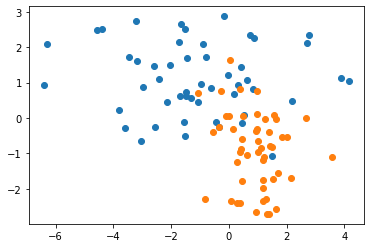

In [ ]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
X = np.concatenate([X0, X1], axis=0)
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))


plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

### Model family

Next, we construct a linear model.

In [ ]:
def model(x, w):
    return np.dot(x, w)

Let's try it out.

In [ ]:
w = np.array([-0.5, -0.2])

model(X0[0], w)

-0.2725555518098268

We can plot the decision boundary, or the area in data space where the model flips from a negative to a positive prediction

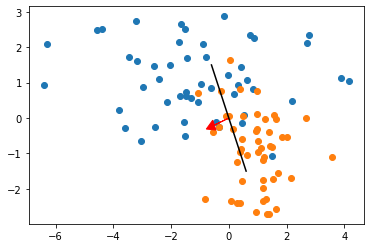

In [ ]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

### Cost function

How good is the model on a single input-output training pair?

In [ ]:
def loss(a, b):
    return (a - b)**2

What is the average loss on a data set of multiple pairs?

In [ ]:
def average_loss(w, data):
    c = 0
    for x, y in data:
        prediction = model(x, w)
        c += loss(prediction, y)
    return c/len(data)

In [ ]:
w = np.array([1.3, -0.4])
average_loss(w, data)

5.722260041954332

## 2. Gradients

Because we imported PennyLane's numpy version, we can now compute gradients of the average loss with respect to the weights!

In [ ]:
gradient_fn = qml.grad(average_loss, argnum=0)
gradient_fn(w, data)

array([ 9.04721722, -2.72486769])

We can use gradients to guess better candidates for parameters.

In [ ]:
w_new = w - 0.05*gradient_fn(w, data)

In [ ]:
average_loss(w_new, data)

3.630609678408535

This works because the gradient always points towards the steepest ascent in the cost landscape.

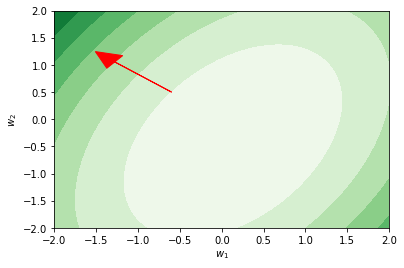

In [ ]:
# compute the gradient at some point in parameter space
some_w = np.array([-0.6, 0.5])
g = 0.01*gradient_fn(some_w, data)

# make a contourplot of the cost
w1s = np.linspace(-2, 2)
w2s = np.linspace(-2, 2)
cost_grid = []
for w1 in w1s:
    for w2 in w2s:
        w = np.array([w1, w2])
        cost_grid.append(average_loss(w, data))
cost_grid = np.array(cost_grid).reshape((50, 50))
plt.contourf(w1s, w2s, cost_grid.T, cmap=cmap)

plt.arrow(some_w[0], some_w[1], some_w[0] + g[0], some_w[1] + g[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.show()

## 3. Training

Putting it all together, we can train the linear model.

In [ ]:
w_init = np.random.random(size=(2,))
w = np.array(w_init)

history = []
for i in range(15):
    w_new = w - 0.05*gradient(w, data)
    print(average_loss(w_new, data))
    history.append(w_new)
    w = w_new

1.5144018097026404
1.1808508370191566
0.9679057872944832
0.8225497121259187
0.7200707131234833
0.6467650044374743
0.5939964244070769
0.5559089393565819
0.5283865622857313
0.5084889919125516
0.49410089930183554
0.4836958516584911
0.4761709495674783
0.4707288764704334
0.4667930971746499


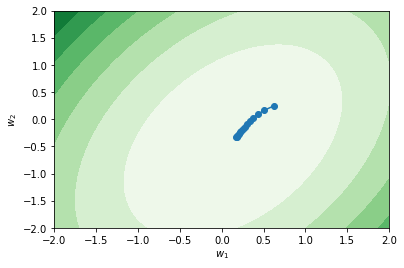

In [ ]:
plt.contourf(w1s, w2s, cost_grid.T, cmap=cmap)
history = np.array(history)
plt.plot(history[:, 0], history[:, 1], "-o")
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.show()

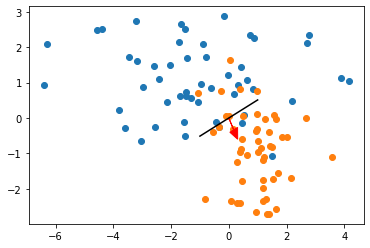

In [ ]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

#  ====== TASKS =============



1. Add a constant scalar bias term $b \in \mathbb{R}$ to the model,

    $$ f(x, w) = \langle w, x \rangle + b, $$

   and train both $w$ and $b$ at the same time.
   

2. Change the model to a neural network with a single hidden layer.

    $$ f(x, w, W) = \langle w, \varphi(Wx) \rangle,$$

   where $W$ is a weight matrix of suitable dimension and $\varphi$ a hand-coded nonlinar activation function. 
   
   Tipp: You can use the vector-valued sigmoid function 
   
   ```
   def sigmoid(z):
        return 1/(1 + np.exp(-x))
   ```
   

3. Code up the above example using PyTorch.